In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from delase import DeLASE
from delase.dmd import embed_signal_torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
from sklearn.decomposition import PCA
import socket

In [3]:
hostname = socket.gethostname()
if 'endeavour' in hostname:
    data = pd.read_pickle('/home/adameisen/Documents/data/ChaoticConsciousness/data_for_sarthak.pkl')
else:
    data = pd.read_pickle("/om/user/eisenaj/ChaoticConsciousness/data/data_for_sarthak.pkl")

In [4]:
import sys
sys.path.append('../..')
from data_utils import filter_data


In [5]:
lfp_w = data["wake_lfps"]
lfp_a = data["anesthesia_lfps"]

In [6]:
lfp_wn = (data["wake_lfps"] - np.mean(data["wake_lfps"]))/np.std(data["wake_lfps"])
lfp_an = (data["anesthesia_lfps"] - np.mean(data["anesthesia_lfps"]))/np.std(data["anesthesia_lfps"])

# lfp_wn = (data["wake_lfps"] - np.mean(data["wake_lfps"], axis=0))/np.std(data["wake_lfps"], axis=0)
# lfp_an = (data["anesthesia_lfps"] - np.mean(data["anesthesia_lfps"], axis=0))/np.std(data["anesthesia_lfps"], axis=0)

In [7]:
delase_w = DeLASE(lfp_w, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_a = DeLASE(lfp_a, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_wn = DeLASE(lfp_wn, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_an = DeLASE(lfp_an, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)

In [8]:
delase_w.fit()
delase_wn.fit()
delase_a.fit()
delase_an.fit()

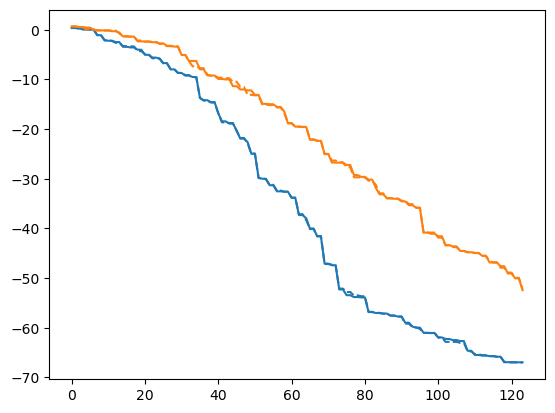

In [9]:
plt.plot(delase_w.stability_params.cpu()[:int(0.1*len(delase_w.stability_params))])
plt.plot(delase_wn.stability_params.cpu()[:int(0.1*len(delase_wn.stability_params))], c='C0', linestyle='--')
plt.plot(delase_a.stability_params.cpu()[:int(0.1*len(delase_a.stability_params))])
plt.plot(delase_an.stability_params.cpu()[:int(0.1*len(delase_an.stability_params))], c='C1', linestyle='--')
plt.show()

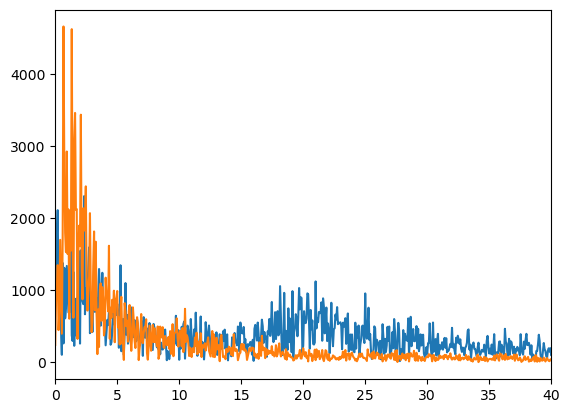

In [10]:
freqs = np.fft.rfftfreq(lfp_wn.shape[0], d=1/1000)
plt.plot(freqs, np.abs(np.fft.rfft(lfp_wn[:, 0])))
plt.plot(freqs, np.abs(np.fft.rfft(lfp_an[:, 0])), c='C1')
plt.xlim([0, 40])
plt.show()

In [41]:
low_pass = 0.1
high_pass = 4

# low_pass = None
# high_pass = 12

# low_pass = 30
# high_pass = 80

order = 10

lfp_wf = filter_data(lfp_w, low_pass, high_pass, dt=0.001, order=order)
lfp_af = filter_data(lfp_a, low_pass, high_pass, dt=0.001, order=order)

lfp_wfn = filter_data(lfp_wn, low_pass, high_pass, dt=0.001, order=order)
lfp_afn = filter_data(lfp_an, low_pass, high_pass, dt=0.001, order=order)

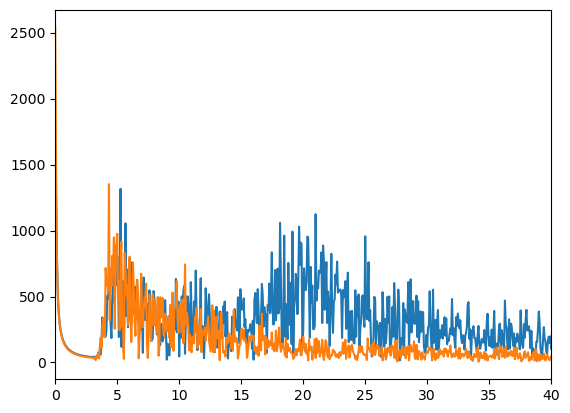

In [42]:
freqs = np.fft.rfftfreq(lfp_wn.shape[0], d=1/1000)
plt.plot(freqs, np.abs(np.fft.rfft(lfp_wfn[:, 0])))
plt.plot(freqs, np.abs(np.fft.rfft(lfp_afn[:, 0])), c='C1')
plt.xlim([0, 40])
plt.show()

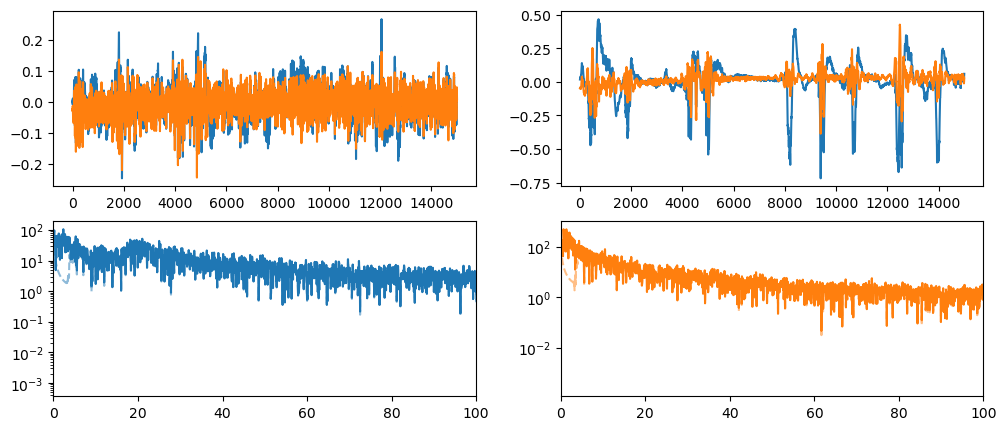

In [43]:
plt.figure(figsize=(12, 5))
plt.subplot(2, 2, 1)
plt.plot(lfp_w[:, 0])
plt.plot(lfp_wf[:, 0])
plt.subplot(2, 2, 2)
plt.plot(lfp_a[:, 0])
plt.plot(lfp_af[:, 0])
plt.subplot(2, 2, 3)
freqs = np.fft.rfftfreq(lfp_w.shape[0], d=1/1000)
plt.plot(freqs, np.abs(np.fft.rfft(lfp_w[:, 0])))
plt.plot(freqs, np.abs(np.fft.rfft(lfp_wf[:, 0])), c='C0', alpha=0.5, linestyle='--')
plt.xlim([0, 100])
plt.yscale('log')
plt.subplot(2, 2, 4)
plt.plot(freqs, np.abs(np.fft.rfft(lfp_a[:, 0])), c='C1')
plt.plot(freqs, np.abs(np.fft.rfft(lfp_af[:, 0])), c='C1', alpha=0.5, linestyle='--')
plt.xlim([0, 100])
plt.yscale('log')

plt.show()

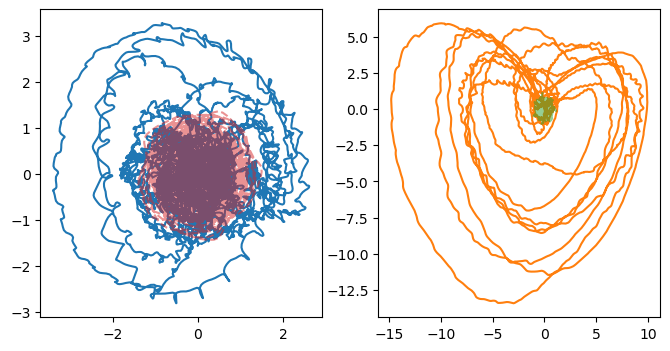

In [37]:
pca = PCA(n_components=2)
n_delays = 15
delay_interval = 20
lfp_w_pca = pca.fit_transform(embed_signal_torch(lfp_w, n_delays, delay_interval))
lfp_wf_pca = pca.fit_transform(embed_signal_torch(lfp_wf, n_delays, delay_interval))
lfp_a_pca = pca.fit_transform(embed_signal_torch(lfp_a, n_delays, delay_interval))
lfp_af_pca = pca.fit_transform(embed_signal_torch(lfp_af, n_delays, delay_interval))
plt.figure(figsize=(8, 4))
# plt.suptitle('Swapping phase of {}-{} Hz Band\nDelay Embedded with {} delays and {} ms lag'.format(min_freq, max_freq, n_delays, delay_interval))

plt.subplot(1, 2, 1)
plt.plot(lfp_w_pca[:, 0], lfp_w_pca[:, 1])
plt.plot(lfp_wf_pca[:, 0], lfp_wf_pca[:, 1], c='C3', alpha=0.5, linestyle='--')
plt.subplot(1, 2, 2)
plt.plot(lfp_a_pca[:, 0], lfp_a_pca[:, 1], c='C1')
plt.plot(lfp_af_pca[:, 0], lfp_af_pca[:, 1], c='C2', alpha = 0.5, linestyle='--')
plt.show()


In [44]:
delase_w = DeLASE(lfp_w, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_wf = DeLASE(lfp_wf, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
# delase_wfn = DeLASE(lfp_wfn, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_a = DeLASE(lfp_a, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_af = DeLASE(lfp_af, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)  
# delase_afn = DeLASE(lfp_afn, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)  

In [45]:
delase_w.fit()
delase_wf.fit()
# delase_wfn.fit()
delase_a.fit()
delase_af.fit()
# delase_afn.fit()

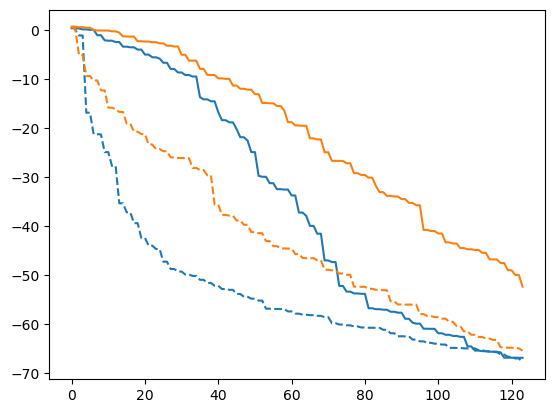

In [46]:
plt.plot(delase_w.stability_params.cpu()[:int(0.1*len(delase_w.stability_params))])
plt.plot(delase_wf.stability_params.cpu()[:int(0.1*len(delase_wf.stability_params))], c='C0', linestyle='--')
# plt.plot(delase_wfn.stability_params.cpu()[:int(0.1*len(delase_wf.stability_params))], c='C0', linestyle='-.')
plt.plot(delase_a.stability_params.cpu()[:int(0.1*len(delase_a.stability_params))])
plt.plot(delase_af.stability_params.cpu()[:int(0.1*len(delase_af.stability_params))], c='C1', linestyle='--')
# plt.plot(delase_afn.stability_params.cpu()[:int(0.1*len(delase_af.stability_params))], c='C1', linestyle='-.')
plt.show()

In [14]:
min_freq = 0.1
max_freq = 4

lfp_ws = np.zeros(lfp_w.shape)
lfp_as = np.zeros(lfp_a.shape)

for i in range(lfp_a.shape[1]):
    fft_result_w = np.fft.rfft(lfp_w[:, i])
    magnitude_w = np.abs(fft_result_w)
    phase_w = np.angle(fft_result_w)

    fft_result_a = np.fft.rfft(lfp_a[:, i])
    freqs = np.fft.rfftfreq(lfp_a.shape[0], 0.001)
    magnitude_a = np.abs(fft_result_a)
    phase_a = np.angle(fft_result_a)
    
    freq_inds = (freqs > min_freq) & (freqs < max_freq)

    phase_a_temp = phase_a[freq_inds].copy()
    phase_a[freq_inds] = phase_w[freq_inds]
    phase_w[freq_inds] = phase_a_temp
    # phase_a[freq_inds] = np.random.uniform(0, 2*np.pi, sum(freq_inds))
    # phase_a[freq_inds] = 0
    lfp_ws[:, i] = np.fft.irfft(magnitude_w * np.exp(1j * phase_w))
    lfp_as[:, i] = np.fft.irfft(magnitude_a * np.exp(1j * phase_a))

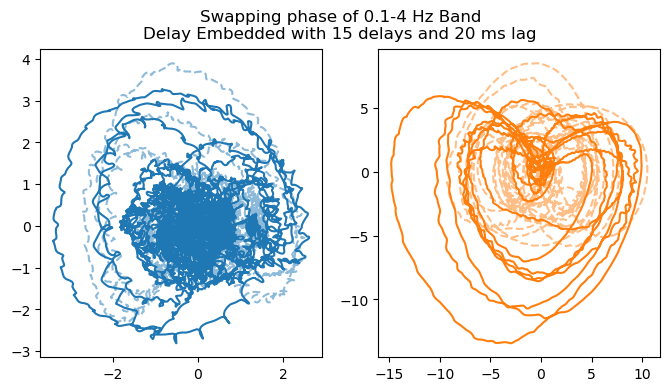

In [15]:
pca = PCA(n_components=2)
n_delays = 15
delay_interval = 20
lfp_w_pca = pca.fit_transform(embed_signal_torch(lfp_w, n_delays, delay_interval))
lfp_ws_pca = pca.fit_transform(embed_signal_torch(lfp_ws, n_delays, delay_interval))
lfp_a_pca = pca.fit_transform(embed_signal_torch(lfp_a, n_delays, delay_interval))
lfp_as_pca = pca.fit_transform(embed_signal_torch(lfp_as, n_delays, delay_interval))
plt.figure(figsize=(8, 4))
plt.suptitle('Swapping phase of {}-{} Hz Band\nDelay Embedded with {} delays and {} ms lag'.format(min_freq, max_freq, n_delays, delay_interval))

plt.subplot(1, 2, 1)
plt.plot(lfp_w_pca[:, 0], lfp_w_pca[:, 1])
plt.plot(lfp_ws_pca[:, 0], lfp_ws_pca[:, 1], c='C0', alpha=0.5, linestyle='--')
plt.subplot(1, 2, 2)
plt.plot(lfp_a_pca[:, 0], lfp_a_pca[:, 1], c='C1')
plt.plot(lfp_as_pca[:, 0], lfp_as_pca[:, 1], c='C1', alpha = 0.5, linestyle='--')
plt.show()


In [16]:
delase_ws = DeLASE(lfp_ws, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_ws.fit()
delase_as = DeLASE(lfp_as, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_as.fit()

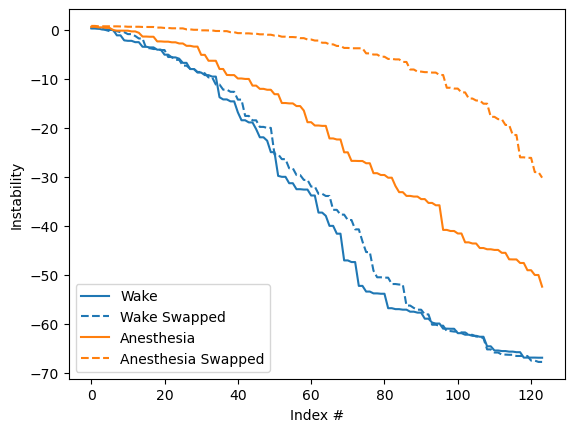

In [17]:
plt.plot(delase_w.stability_params.cpu()[:int(0.1*len(delase_w.stability_params))], label='Wake')
plt.plot(delase_ws.stability_params.cpu()[:int(0.1*len(delase_ws.stability_params))], c='C0', linestyle='--', label='Wake Swapped')
plt.plot(delase_a.stability_params.cpu()[:int(0.1*len(delase_a.stability_params))], c='C1', label='Anesthesia')
plt.plot(delase_as.stability_params.cpu()[:int(0.1*len(delase_as.stability_params))], c='C1', linestyle='--', label='Anesthesia Swapped')
plt.xlabel('Index #')
plt.ylabel('Instability')
plt.legend()
plt.show()

In [23]:
min_freq = 0.1
max_freq = 4

lfp_wf = np.zeros(lfp_w.shape)
for i in range(lfp_w.shape[1]):
    lfp_wf[:, i] = bandstop_filter(lfp_w[:, i], min_freq, max_freq, 1000, order=2)
lfp_af = np.zeros(lfp_a.shape)
for i in range(lfp_a.shape[1]):
    lfp_af[:, i] = bandstop_filter(lfp_a[:, i], min_freq, max_freq, 1000, order=2)
